If you run the code on google colab uncomment you need to run the line below. If you launch the notebook from myBinder.org this will not be necessary.

In [309]:
# !pip install pygfunction matplotlib numpy scipy SecondaryCoolantProps  CoolProp

# Borehole resistance computation

<img src="./resources/figure_borehole_configuration.png" width="320" />

In [311]:
# Base configuration data

# Ground properties 
rho_ground = 2600    #kg/m^3         #density
cp_ground  = 800     # J /(kg K)     #specific heat capacity
k_ground   = 2.8     #W/(m K)        #conductivity    
T_0   =  9          # C             #undisturbed ground temperature 

# Borehole configuration (water&Ethanol 20% mixture)
r_b = 0.06    #m             #borehole radius
k_grout = 1.2 #W/(mK).       #Grout conductivity
k_pipe = 0.33 #W/(mK).       #Pipe conductivity
s = 0.065     #m             #distance between pipe center (assuming symmetric configuration)   
D_i = 0.042   #m             #internal pipe diameter (assuming symmetric configuration)   
D_o = 0.048   #m             #outer pipe diameter (assuming symmetric configuration)   
H =   150     #m             #borehole length. 

# Design mass flow rate
mb  = 0.5	# kg/s

## Fluid Properties 

We can use CoolProp to evaluate the secondary fluid properties 

we are interested in density, specific heat capacity, conductivity, dynamic viscosity and freezing point. Reference to properties names in CoolProp can be found at http://coolprop.org/coolprop/HighLevelAPI.html#table-of-string-inputs-to-propssi-function

The secondary fluid circulating is usually a binary mixture. Reference to Incompressible binary mixtures names available in CoolProp can be found at http://www.coolprop.org/fluid_properties/Incompressibles.html

Fluids that could be used are:
- MEA2 : Melinder, Ethanol
- MEG2: Melinder, Ethylene Glycol
- MPG2: Melinder, Propylene Glycol

The fluid could be also water if it is certain that the temperature will not drop below zero (causing freezing). This is never the case for application involving heat extraction in Sweden.

The base case configuration consider a water and Ethanol 20% mixture.

In [313]:
from CoolProp.CoolProp import PropsSI

Tref = 0 + 273.15
secondaryfluid = 'INCOMP::MEA-20%'

T_freeze = PropsSI('T_freeze',secondaryfluid)
cp_fluid  = PropsSI('C','T',Tref,'P',101325,secondaryfluid)  #specific heat 
rho_fluid = PropsSI('D','T',Tref,'P',101325,secondaryfluid)
mu_fluid  = PropsSI('viscosity','T',Tref,'P',101325,secondaryfluid)
k_fluid  = PropsSI('conductivity','T',Tref,'P',101325,secondaryfluid)

print(f'Tfreeze = {T_freeze - 273.15} °C')
print(f'Tref = {Tref - 273.15} °C')
print(f'cp_fluid = {cp_fluid} J/(kg K)')
print(f'rho_fluid = {rho_fluid} kg/m^3')
print(f'mu_fluid = {mu_fluid} Pa s')
print(f'k_fluid = {k_fluid} W/(m K) ')



Tfreeze = -11.118921788700447 °C
Tref = 0.0 °C
cp_fluid = 4369.391286393766 J/(kg K)
rho_fluid = 975.7653865139208 kg/m^3
mu_fluid = 0.005249271348515964 Pa s
k_fluid = 0.44781845764681294 W/(m K) 


### Fluid to grout resistance 
To evaluate cross-section resistances Rb and Ra we first need to evaluate the resistance between the fluid circulating in the two pipes and the pipe grouting material.

$$R_p= (R_{cond}+R_{conv})/N_p $$

Where $R_{conv}$ is the convective resistance between the fluid and the pipe surface, $R_{cond}$ is the thermal resistance relative to the conduction in the piping material and $N_p$ is the number of pipes in the borehole cross-section.


### Conductive resistance
The conductive resistance in the pipe can be evaluated with the following formula which considers radial conduction in a cylindrical wall, with inner radius r_i and outer radius r_o.
$$R_{cond} = \frac{1}{2 \pi k_{pipe}  } \, \ln⁡(r_o/r_i )$$


### Convective resistance
The convective resistance for pipe flow is equal to  $R_{conv}= \frac{1}{2πr_i h_i  }$ where $h_i$ is the heat transfer coefficient between the fluid and the pipe wall. The heat transfer coefficient is a function of the Nusselt number, the radius $r_i$ and the conductivity  $k_f$.

$$h_i=\frac{\text{Nu} \; k_f}{2 \,r_i  }$$

The Nusselt number is a function of Reynolds and Prandtl numbers defined as follow.

$\text{Re} =(\rho \,v \,2r_i)/\mu$ 	

$\text{Pr} =(\mu \,c_{p_f} )/(2r_i)$

With $\mu$ and $c_{p_f}$ the dynamic viscosity and the specific heat capacity of the fluid. The Reynolds number determines the flow regime based which could be Laminar Flow, Turbulent Flow or Transition region. In literature we can find the correlations belows for Nu(Re,Pr) 


<img src="./resources/formulas_flow_in_pipe.png" width="800" />

In [314]:
import math

def evaluate_nusselt(Re, Pr, mode="heating"):
    if Re < 2300:
        Nu = 3.66
    elif 2300 <= Re < 10000:
        f = (1.58 * math.log(Re) - 3.28) ** (-2)
        Nu = (0.5 * f * (Re - 1000.) * Pr) / (1 + 12.7 * math.sqrt(0.5 * f) * (Pr**(2/3) - 1))
    else:
        n = 0.3 if mode == "heating" else 0.4
        Nu = 0.023 * Re**0.8 * Pr**n
    return Nu

### Computation of section Borehole Resistances


$$ 
R_b = \frac{1}{4 π k_g } \left[\beta + \ln⁡\left(\frac{\theta_2}{2\theta_1 (1 -\theta_1^4)^σ }\right) 
- \frac{(\theta_3^2 (1 -(4\sigma \theta_1^4)/(1 -\theta_1^4 ))^2}{ \frac{(1+\beta)}{(1-\beta)}+\theta_3^2 (1+\frac{16\sigma \theta_1^4)}{(1 - \theta_1^4)^2} }  \right]
$$


$$ 
R_a = \frac{1}{π k_g } \left[β+ \ln⁡ \left( \frac{(1+\theta_1^2)^\sigma}{\theta_3 (1 -\theta_1^2)^\sigma } \right) - 
\frac{θ_3^2 (1 -θ_1^4  +4σθ_1^2 )^2}{\frac{1+β}{1-β} \, (1 -θ_1^4)^2  + θ_3^2 (1 -θ_1^4)^2  + 8σθ_1^2 θ_3^2 (1+θ_1^4)} \right]
$$


Where the parameters $θ_1$, $θ_2$, $θ_3$, $σ$, $β$ are defined as follows

**Geometrical parameters:** 

$ θ_1=s/(2 r_b )  \qquad θ_2=r_b/r_{po}  \qquad θ_3=r_{po}/s=1/(2 θ_1 θ_2 )$

**Thermal parameters:**  

$σ=(λ_g-λ)/(λ_g+λ)	 \qquad β=2πλ_g R_p$


### Effective Borehole Resistance

$\large \eta = \frac{H}{\dot{m} \, c_p \sqrt{(R_a \, R_b )}}$

$R_b^{\star} = R_b \, η \, coth⁡(η)$

In [315]:
def cross_section_Rb(θ1, θ2, θ3, σ, β, kgrout):
    M0 = β + math.log(θ2 / (2 * θ1 * (1 - θ1**4)**σ))
    M1 = θ3**2 * (1 - 4 * σ * θ1**4 / (1 - θ1**4))**2 / ((1 + β) / (1 - β) + θ3**2 * (1 + 16 * σ * θ1**4 / (1 - θ1**4)**2))
    return 1 / (4 * math.pi * kgrout) * (M0 - M1)#, M0, M1

def cross_section_Ra(θ1, θ2, θ3, σ, β, kgrout):
    M0 = β + math.log((1 + θ1**2)**σ / (θ3 * (1 - θ1**2)**σ))
    M1 = θ3**2 * (1 - θ1**4 + 4 * σ * θ1**2)**2 / ((1 + β) / (1 - β) * (1 - θ1**4)**2 + θ3**2 * (1 - θ1**4)**2 + 8 * σ * θ1**2 * θ3**2 * (1 + θ1**4))
    return 1 / (math.pi * kgrout) * (M0 - M1)#, M0, M1

###  Computation
Here we compute the resistances for one set of geometrical, thermophysical and hydraulic parameters

In [316]:
import numpy as np

r_i = D_i/2   # internal pipe radius
r_o = D_o/2   # outer pipe radius

w = mb/(rho_fluid *math.pi*r_i**2)    # secondary fluid velocity
Re = rho_fluid * w * 2*r_i/ mu_fluid  # Reynolds number
Pr = mu_fluid * cp_fluid/(2*r_i)      # Prandtl number
	
Nu = evaluate_nusselt(Re,Pr)          # Nusselt
h_i = Nu*k_fluid/(2*r_i)              # fluid pipe heat transfer coefficient 

Rconv = 1/(2*math.pi *r_i*h_i)        # convection resistance
Rcond = 1/(2*math.pi *k_pipe) * math.log(r_o/r_i)   # conduction resistance§
Rp = (Rcond + Rconv)/2   

θ1 = s/(2*r_b)    # geometrical parameters
θ2 = r_b/r_o
θ3 = r_o/s

σ  = (k_grout - k_ground)/(k_grout + k_ground)     # 
β  = 2*math.pi  * k_grout * Rp 

Rb = cross_section_Rb(θ1, θ2, θ3, σ, β, k_grout)
Ra = cross_section_Ra(θ1, θ2, θ3, σ, β, k_grout)

η = H/(mb*cp_fluid*math.sqrt(Ra*Rb))
Rbstar =  Rb * η * 1/np.tanh(η)

print(f'Reynolds = {Re} \n' )

print(f'Rconv = {Rconv} (m K)/W')
print(f'Rcond = {Rcond} (m K)/W')
print(f'Ra = {Ra} (m K)/W')
print(f'Rb = {Rb} (m K)/W')
print(f'Rbstar = {Rbstar} (m K)/W')


Reynolds = 2887.5652679080513 

Rconv = 0.007707539159318089 (m K)/W
Rcond = 0.0644005490731437 (m K)/W
Ra = 0.26726383896126654 (m K)/W
Rb = 0.0644182396823886 (m K)/W
Rbstar = 0.07019312269363889 (m K)/W


###  Computation over a range of parameters
To compute the resistances for sets of geometrical, thermophysical and hydraulic parameters exploring range of mass flows and borehole length is convenient to define a function call it for over the ranges of parameters

In [317]:
def compute_resistances(mb, H):
    w = mb / (rho_fluid * math.pi * r_i**2)
    Re = rho_fluid * w * 2 * r_i / mu_fluid 
    Pr = mu_fluid * cp_fluid / (2 * r_i)
	
    Nu = evaluate_nusselt(Re, Pr)
    hi = Nu * k_fluid / (2 * r_i)

    Rconv = 1 / (2 * math.pi * r_i * hi) 
    Rcond = 1 / (2 * math.pi * k_pipe) * math.log(r_o / r_i)
    Rp = (Rcond + Rconv) / 2   

    θ1 = s / (2 * r_b)
    θ2 = r_b / r_o
    θ3 = r_o / s

    σ  = (k_grout - k_ground) / (k_grout + k_ground)
    β  = 2 * math.pi * k_grout * Rp 

    Rb = cross_section_Rb(θ1, θ2, θ3, σ, β, k_grout)
    Ra = cross_section_Ra(θ1, θ2, θ3, σ, β, k_grout)

    η = H / (mb * cp_fluid * math.sqrt(Ra * Rb))
    Rbstar =  Rb * η * (1 / math.tanh(η))
    return Rbstar

In [318]:
import numpy as np

# Define ranges for m and H
m_range = np.arange(0.2, 1.05, 0.05)
H_range = np.arange(100, 401, 50)

# Initialize an empty list to store results
Rbstar_matrix = []

# Iterate over m and H values and compute resistances
for m in m_range:
    row = []
    for H in H_range:
        row.append(compute_resistances(m, H))
    Rbstar_matrix.append(row)

# Convert the list to a numpy array
Rbstar_matrix = np.array(Rbstar_matrix)

We can then make some plots

In [319]:
import numpy as np

# Define ranges for m and H
m_range = np.arange(0.2, 1.05, 0.05)
H_range = np.arange(100, 401, 50)

# Preallocate the matrix with zeros
rows = len(m_range)
cols = len(H_range)
Rbstar_matrix = np.zeros((rows, cols))

# Iterate over m and H values and compute resistances
for i, m in enumerate(m_range):
    for j, H in enumerate(H_range):
        Rbstar_matrix[i, j] = compute_resistances(m, H)

/var/folders/rf/mqm71pmd1kz2mz2d4n25s3740000gp/T/ipykernel_89342/1204383233.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('RdBu')


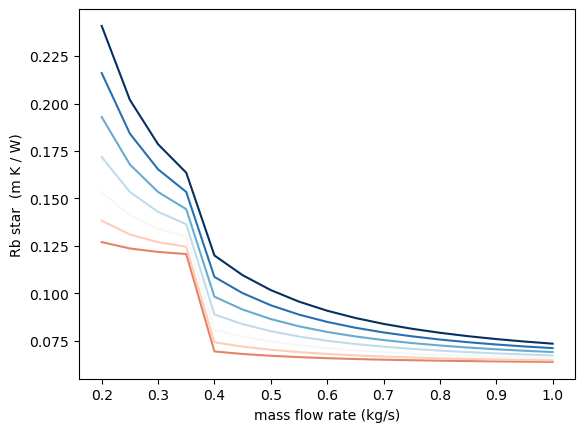

In [321]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors




fig, (ax1) = plt.subplots(1, 1)

# Plot each line with a different color based on its index
for i in range(len(H_range)):
    color = colors(H_range[i]/H_range[-1] )  # Get color from the colormap based on index
    ax1.plot(m_range, Rbstar_matrix[:,i], color=color)

ax1.set_xlabel('mass flow rate (kg/s)')
ax1.set_ylabel('Rb star  (m K / W)')

# # setup the colorbar
# scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
# scalarmappaple.set_array(nValues)
# plt.colorbar(scalarmappaple)


# Show plot
plt.show()
